In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
!pip install mediapipe
import mediapipe as mp
import os
import json

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
input_json_path = '/content/drive/Shareddrives/URSI 2022/Eye Tracking ML/json_inputs/'

all_input_json_files = os.listdir(input_json_path)

input_json_data = {}
with open(input_json_path + all_input_json_files[36], 'r') as file:
    s_data = json.load(file)
    input_json_data = {**input_json_data, **s_data}

In [3]:
calibration_points = [[10, 50], [10, 10], [90, 10], [50, 90],
                   [30, 70], [50, 50], [50, 10], [90, 90],
                   [70, 70], [70, 30], [10, 90], [90, 50],
                   [30, 30]]

In [4]:
train_y = []

for subject in input_json_data:
    for y in input_json_data[subject]['y']:
        train_y.append(y)
        for element in calibration_points:
            train_y.append(element)

print(len(train_y))
#print(train_y)

1260


In [5]:
train_x = []

for subject in input_json_data:
    for sample in input_json_data[subject]['x']:
        calibration_arr = []
        for point in sample:
            total_arr = []
            head_pose = np.array(point[0])
            iris_points = np.array(point[1])
            head_pose = head_pose.flatten()
            iris_points = iris_points.flatten()
            #for element in head_pose:
                #total_arr.append(element)
            for element in iris_points:
                total_arr.append(element)
            calibration_arr.append(total_arr)
        #train_x.append(calibration_arr[0])
        for element in calibration_arr:
            train_x.append(element)

In [6]:
print(np.shape(train_x))
print(np.shape(train_y))

(1260, 16)
(1260, 2)


In [7]:
train_x = np.array(train_x)
mean = train_x.mean(axis=0)
train_x -= mean
std = train_x.std(axis=0)
train_x /= std
train_y = np.array(train_y)

In [8]:
from sklearn.utils import shuffle

train_x, train_y = shuffle(train_x, train_y)

In [9]:
print(np.shape(train_x))
print(np.shape(train_y))

(1260, 16)
(1260, 2)


In [10]:
val_x = train_x[0:(int((len(train_x)) / 4))]
val_y = train_y[0:(int((len(train_y)) / 4))]
train_x = train_x[(int((len(train_x)) / 4)):int(len(train_x))]
#train_x = train_x[(int((len(train_x)) / 2)):(int((len(train_x)) / 2 + 2))]

train_y = train_y[(int((len(train_y)) / 4)):int(len(train_y))]
#train_y = train_y[(int((len(train_y)) / 2)):(int((len(train_y)) / 2 + 2))]

In [11]:
print(np.shape(train_x))
print(np.shape(train_y))

(945, 16)
(945, 2)


In [12]:
print(np.shape(val_x))
print(np.shape(val_y))

(315, 16)
(315, 2)


In [13]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([layers.Dense(128, activation="relu"), layers.Dense(64, activation="relu"), layers.Dense(16, activation="relu"), layers.Dense(2, activation="relu")])
model.compile(optimizer=keras.optimizers.RMSprop(1e-2), loss="MeanSquaredError", metrics=["mae"])

history = model.fit(train_x, train_y, epochs=70, batch_size=40000, validation_data=(val_x, val_y))

Epoch 1/70
1/1 [==============================] - 1s 1s/step - loss: 3341.8955 - mae: 49.9011 - val_loss: 3109.6863 - val_mae: 47.7915
Epoch 2/70
1/1 [==============================] - 0s 32ms/step - loss: 3102.9165 - mae: 47.5616 - val_loss: 2439.0693 - val_mae: 42.2840
Epoch 3/70
1/1 [==============================] - 0s 32ms/step - loss: 2456.9207 - mae: 41.9910 - val_loss: 1961.1536 - val_mae: 35.2336
Epoch 4/70
1/1 [==============================] - 0s 32ms/step - loss: 2038.4464 - mae: 35.5822 - val_loss: 2037.7875 - val_mae: 36.6159
Epoch 5/70
1/1 [==============================] - 0s 35ms/step - loss: 2052.0740 - mae: 36.4803 - val_loss: 1973.4734 - val_mae: 34.7104
Epoch 6/70
1/1 [==============================] - 0s 31ms/step - loss: 2016.1931 - mae: 34.7569 - val_loss: 2045.4337 - val_mae: 37.0617
Epoch 7/70
1/1 [==============================] - 0s 53ms/step - loss: 2059.9058 - mae: 36.8737 - val_loss: 1832.0597 - val_mae: 33.0392
Epoch 8/70
1/1 [===========================

10/10 [==============================] - 0s 2ms/step


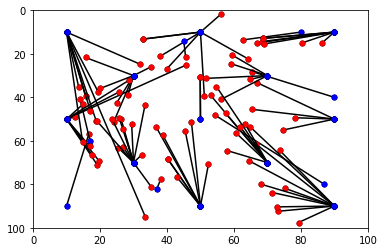

In [14]:
plt.xlim(0, 100)
plt.ylim(100, 0)
x2 = []
y2 = []
sample_num = 0
while sample_num <= 90:
    x = [val_y[sample_num][0]]
    x2 = [(val_y[sample_num][0])]
    x.append(model.predict(val_x)[sample_num][0])
    x3 = [model.predict(val_x)[sample_num][0]]
    y = [val_y[sample_num][1]]
    y2 = [(val_y[sample_num][1])]
    y.append(model.predict(val_x)[sample_num][1])
    y3 = [model.predict(val_x)[sample_num][1]]
    plt.plot(x, y, color="black", marker="o", markersize=5)
    plt.plot(x3, y3, color="red", marker="o", markersize=5)
    plt.plot(x2, y2, color="blue", marker="o", markersize=5)
    sample_num += 1



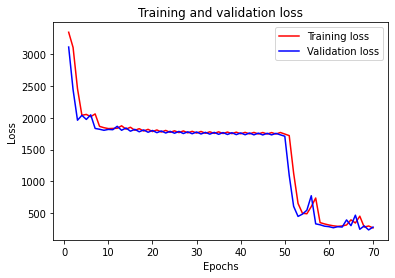

In [15]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "r", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

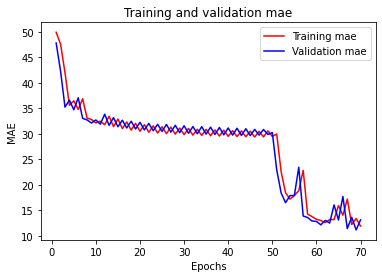

In [16]:
plt.clf()
acc = history_dict["mae"]
val_acc = history_dict["val_mae"]
plt.plot(epochs, acc, "r", label="Training mae")
plt.plot(epochs, val_acc, "b", label="Validation mae")
plt.title("Training and validation mae")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()